In [55]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.backend import clear_session
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from tqdm import tqdm
from numpy.random import seed
import tensorflow as tf
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [56]:
#Data Parameters
num_of_classes = 54
data_shape = (520,1)

#MLP Parameters
times_to_run = 30 #Number of times to run MLP model
mlp_epochs = 30
valid_split = 0.20

#GAN Parameters
latent_dim = 200
gan_epochs = 50

#Random Seeds
selection_seed = 150
seed_multiplier = 1000000

In [109]:
#一个图形化界面
cb1 = widgets.Checkbox(description="Generate missing data only")
slider1 = widgets.FloatSlider(value=0.2, min=0.1, max=1, step=0.1)
slider2 = widgets.IntSlider(value=5, min=5, max=40, step=5)
vb = widgets.VBox(children = [slider2])
def checkbox(button):
    if button['new']:
        vb.children = []
        slider2.value = 250 - int(slider1.value*250) 
    else:
        vb.children = [slider2]
        experiment3 = False
cb1.observe(checkbox, names='value')

print("Percentage of Real Data:")
display(slider1)
print("Number of datapoints GAN generates:")
display(vb)
display(cb1)

Percentage of Real Data:


FloatSlider(value=0.2, max=1.0, min=0.1)

Number of datapoints GAN generates:


Checkbox(value=False, description='Generate missing data only')

In [111]:
fraction_of_data = slider1.value
data_to_gen = slider2.value
fraction_of_data,data_to_gen

(0.2, 10)

In [112]:
dataset = pd.read_csv("./UJIIndoorLoc/children_13/sorted/00_sorted.csv")
dataset["REF"] = pd.factorize(dataset["REF"])[0].astype(int)#将标签映射到顺序数字上
labels = dataset.REF.values
features = dataset.drop(columns=['TIMESTAMP','PHONEID','USERID','RELATIVEPOSITION',
                                'SPACEID','BUILDINGID','FLOOR','LATITUDE','LONGITUDE',
                                'REF','BF']).values
labels,features.shape,features

(array([ 0,  0,  0, ..., 53, 53, 53]),
 (1059, 520),
 array([[-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        ...,
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110]], dtype=int64))

In [113]:
X_tr, X_test, Y_tr, Y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2,
                                                    random_state= selection_seed,
                                                    #random_state：可以理解为随机数种子，主要是为了复现结果而设置
                                                    stratify=labels)#stratify保证测试集中，所有类别的齐全
X_tr,X_train.shape,Y_tr,Y_train.shape

(array([[-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        ...,
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110],
        [-110, -110, -110, ..., -110, -110, -110]], dtype=int64),
 (154, 520),
 array([ 3, 13, 45, 14,  6, 22, 15, 10,  8, 29, 48, 26,  9, 36,  0, 19, 13,
         5, 20, 44, 18, 44, 34, 17, 19,  4, 11, 45, 13, 51, 26, 22, 13, 53,
        27, 32, 44, 25, 50, 46, 28, 19,  5, 32, 45, 49, 16,  8, 24,  9, 46,
        39, 51, 13, 15, 42, 14, 34, 17, 12, 40, 42,  7,  4, 15, 40, 24, 37,
        28,  6, 21, 37, 35, 16, 27, 27, 31, 50, 37, 52, 24, 41, 21, 42, 38,
        35, 53, 31, 46, 29, 29, 47,  5, 26, 18, 12, 35, 22, 17, 20, 20, 23,
         1, 41, 33, 42, 17,  5, 50, 25, 25, 13, 21, 21, 24, 17, 27, 12,  3,
        18, 12, 24, 14, 38, 21, 45, 25, 25, 13,  8, 25, 25, 27, 23, 39,  7,
        14, 50, 33,  4, 19, 33, 28, 46, 47, 2

In [114]:
X_train = []
Z_train = [] #This is the same as X_train, but it's used for training the GAN
Y_train = []

for idx in range(54):
    number_filter = np.where(Y_tr == idx)
    X_filtered, Y_filtered = X_tr[number_filter], Y_tr[number_filter]

    num_of_data = (int)(fraction_of_data*X_filtered.shape[0])
    RandIndex = np.random.choice(X_filtered.shape[0], 
                                 num_of_data, 
                                 replace=False)
    Z_train.append(X_filtered[RandIndex])#append添加是将容器看作整体来进行添加，但extend是将容器打碎后添加（加入的只是元素）
    X_train.extend(X_filtered[RandIndex])
    Y_train.extend(Y_filtered[RandIndex])
# X_train,Z_train
X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)
# X_train
#random.shuffle只能对一维list和两维list进行数据打乱
#numpy.random.shuffle可以对列表和数组进行数据打乱
#from sklearn.utils import shuffle中的shuffle可以直接打乱
X_train, Y_train = shuffle(X_train, Y_train)

#将类别向量映射为二值类别矩阵, 用于应用到以categorical_crossentropy为目标函数的模型中.
#to_categorical和pd.get_dummies推荐前者，后者原理更复杂
Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)

In [115]:
#Data must be standized using standard scaler before using the MLP.
scaler = StandardScaler()  #from sklearn.preprocessing import StandardScaler
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)
X_train_transformed.shape

(154, 520)

### 只使用fraction_of_data比例的真数据进行分类

In [116]:
all_test_loss =[]
all_test_acc = []
history = []

for i in tqdm_notebook(range(times_to_run)):
    seed(i*seed_multiplier)#操作级
    tf.random.set_seed(i*seed_multiplier)#图级
    model = Sequential()
    model.add(Dense(1024, input_shape=(520,), activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(54, activation='softmax'))

    model.compile(optimizer=Adam(0.0002, 0.5),#learning rate, the exponential decay rate for the 1st moment estimates
                                              # 学习率      , 一阶矩估计的指数衰减率
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history_temp = model.fit(X_train_transformed,
                            Y_train_encoded,
                            epochs=mlp_epochs,
                            batch_size=32,
                            validation_split=valid_split,
                            verbose=0)
    history.append(history_temp)
    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)

    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    del(model)
    clear_session()

C:\Users\xfp\AppData\Local\Temp\ipykernel_7152\2378831021.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(times_to_run)):


  0%|          | 0/30 [00:00<?, ?it/s]

(2.4032034635543824, 0.44135220249493917)

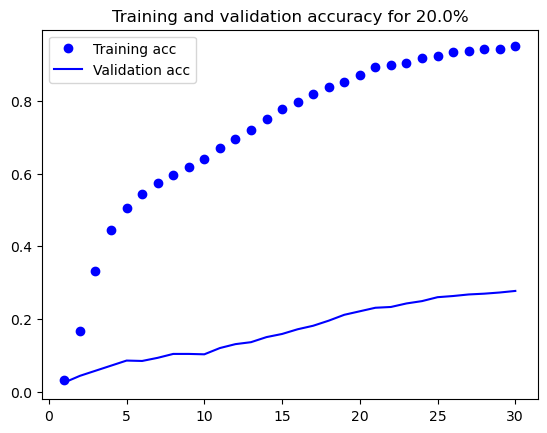

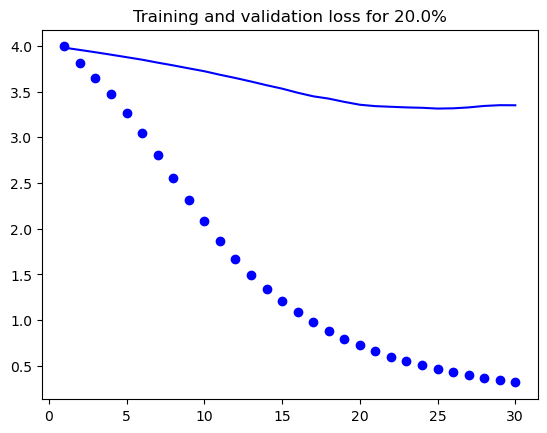

In [117]:
trainacc = []
trainloss = []
valacc = []
valloss = []
for i in range (len(history)):
    trainacc.append(history[i].history['accuracy'])
    trainloss.append(history[i].history['loss'])
    valacc.append(history[i].history['val_accuracy'])
    valloss.append(history[i].history['val_loss'])

acc = np.mean(trainacc, axis=0)
val_acc = np.mean(valacc, axis=0)
loss = np.mean(trainloss, axis=0)
val_loss = np.mean(valloss, axis=0)
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for {}%'.format(fraction_of_data*100))
plt.legend()#作用是加上图例，很有必要
plt.figure()#创建新图
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for {}%'.format(fraction_of_data*100))
# plt.legend()
# plt.savefig("./results/original/Train - {}%.png".format(fraction_of_data*100))
test_loss = np.mean(all_test_loss, axis=0)
test_acc = np.mean(all_test_acc, axis=0)
test_loss,test_acc

## 生成合成数据

In [118]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))#经典值为0.9
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(data_shape), activation='tanh'))
    model.add(Reshape(data_shape))

#     model.summary()

    noise = Input(shape=(latent_dim,))
    gendata = model(noise)
    
    return Model(noise, gendata) #keras.models.Model(input,output) 模型起始输入和最终输出 #Sequential()继承于Model

In [119]:
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=data_shape))#keras.layers.Flatten将数据压成一维的
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))#二分类一般使用sigmoid 和softmax

    #model.summary()

    data = Input(shape=data_shape)
    validity = model(data)

    return Model(data, validity)

In [120]:
def train(epochs, features, batch_size):

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
            idx = np.random.randint(0, features.shape[0], batch_size)
            data = features[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_data = generator.predict(noise) #generator

            d_loss_real = discriminator.train_on_batch(data, valid)
            d_loss_fake = discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #损失函数应该还可以改进

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = combined.train_on_batch(noise, valid) #combined

### 训练gan

In [121]:
gen_data = []

for i in tqdm(range(num_of_classes)):
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=Adam(0.0002, 0.5),
                          metrics=['accuracy'])
    
    generator = build_generator()
    noise = Input(shape=(latent_dim,))
    gendata = generator(noise)
    discriminator.trainable = False#禁用了判别器的参数更新
    validity = discriminator(gendata)
    combined = Model(noise, validity)#连接生成器和判别器
    combined.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.0002, 0.5))

    minimaxscaler = MinMaxScaler((-1,1))#归一化到（-1，1）之间 #from sklearn.preprocessing import MinMaxScaler
    Z_train_transformed = minimaxscaler.fit_transform(Z_train[i])
    Z_train_transformed = np.expand_dims(Z_train_transformed, axis=2)#扩充维度（*，*，1）

    train(epochs=gan_epochs,
          features=Z_train_transformed,
          batch_size=8)
        
    noise = np.random.normal(0, 1, (data_to_gen, latent_dim))
    gen_data_temp = generator.predict(noise)
    gen_data_temp = np.asarray(gen_data_temp, dtype=np.float32)
    gen_data_temp = np.squeeze(gen_data_temp)#删除维度为1 #（1，2，5）==> （2，5）
    gen_data_temp = minimaxscaler.inverse_transform(gen_data_temp) #将归一化数据转回来

    gen_data.append(gen_data_temp)

    clear_session()
    #在每折的开头都需要加上clear_session()。否则上一折的训练集成了这一折的验证集，数据泄露。
    #同时，不清空的话，那么graph上的node越来越多，内存问题，时间问题都会变得严峻。
    #可以有效解决模型的内存占用问题
    del(discriminator)
    del(generator)
    del(combined)

gen_data = np.asarray(gen_data, dtype=np.float32)

  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|█▌                                                                                 | 1/54 [00:08<07:04,  8.01s/it]

1/1 [==============================] - 0s 23ms/step


  4%|███                                                                                | 2/54 [00:15<06:37,  7.65s/it]

1/1 [==============================] - 0s 21ms/step


  6%|████▌                                                                              | 3/54 [00:22<06:27,  7.61s/it]

1/1 [==============================] - 0s 22ms/step


  7%|██████▏                                                                            | 4/54 [00:30<06:12,  7.46s/it]

1/1 [==============================] - 0s 28ms/step


  9%|███████▋                                                                           | 5/54 [00:38<06:19,  7.75s/it]

1/1 [==============================] - 0s 26ms/step


 11%|█████████▏                                                                         | 6/54 [00:47<06:38,  8.30s/it]

1/1 [==============================] - 0s 21ms/step


 13%|██████████▊                                                                        | 7/54 [00:55<06:21,  8.12s/it]

1/1 [==============================] - 0s 25ms/step


 15%|████████████▎                                                                      | 8/54 [01:04<06:29,  8.47s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█████████████▊                                                                     | 9/54 [01:12<06:08,  8.19s/it]

1/1 [==============================] - 0s 22ms/step


 19%|███████████████▏                                                                  | 10/54 [01:20<05:56,  8.11s/it]

1/1 [==============================] - 0s 25ms/step


 20%|████████████████▋                                                                 | 11/54 [01:27<05:42,  7.97s/it]

1/1 [==============================] - 0s 20ms/step


 22%|██████████████████▏                                                               | 12/54 [01:35<05:27,  7.79s/it]

1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▋                                                              | 13/54 [01:42<05:13,  7.65s/it]

1/1 [==============================] - 0s 27ms/step


 26%|█████████████████████▎                                                            | 14/54 [01:50<05:04,  7.61s/it]

1/1 [==============================] - 0s 61ms/step


 28%|██████████████████████▊                                                           | 15/54 [01:58<05:09,  7.93s/it]

1/1 [==============================] - 0s 19ms/step


 30%|████████████████████████▎                                                         | 16/54 [02:06<05:03,  7.97s/it]

1/1 [==============================] - 0s 16ms/step


 31%|█████████████████████████▊                                                        | 17/54 [02:13<04:39,  7.57s/it]

1/1 [==============================] - 0s 16ms/step


 33%|███████████████████████████▎                                                      | 18/54 [02:20<04:28,  7.46s/it]

1/1 [==============================] - 0s 16ms/step


 35%|████████████████████████████▊                                                     | 19/54 [02:27<04:12,  7.20s/it]

1/1 [==============================] - 0s 16ms/step


 37%|██████████████████████████████▎                                                   | 20/54 [02:33<03:57,  7.00s/it]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▉                                                  | 21/54 [02:41<03:58,  7.22s/it]

1/1 [==============================] - 0s 16ms/step


 41%|█████████████████████████████████▍                                                | 22/54 [02:48<03:48,  7.15s/it]

1/1 [==============================] - 0s 6ms/step


 43%|██████████████████████████████████▉                                               | 23/54 [02:55<03:37,  7.03s/it]

1/1 [==============================] - 0s 16ms/step


 44%|████████████████████████████████████▍                                             | 24/54 [03:02<03:28,  6.93s/it]

1/1 [==============================] - 0s 20ms/step


 46%|█████████████████████████████████████▉                                            | 25/54 [03:09<03:23,  7.01s/it]

1/1 [==============================] - 0s 20ms/step


 48%|███████████████████████████████████████▍                                          | 26/54 [03:16<03:17,  7.04s/it]

1/1 [==============================] - 0s 16ms/step


 50%|█████████████████████████████████████████                                         | 27/54 [03:23<03:12,  7.14s/it]

1/1 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████▌                                       | 28/54 [03:30<03:04,  7.10s/it]

1/1 [==============================] - 0s 31ms/step


 54%|████████████████████████████████████████████                                      | 29/54 [03:37<02:54,  7.00s/it]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████████████████████████████▌                                    | 30/54 [03:44<02:44,  6.85s/it]

1/1 [==============================] - 0s 16ms/step


 57%|███████████████████████████████████████████████                                   | 31/54 [03:50<02:35,  6.75s/it]

1/1 [==============================] - 0s 7ms/step


 59%|████████████████████████████████████████████████▌                                 | 32/54 [03:57<02:26,  6.67s/it]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████████                                | 33/54 [04:03<02:19,  6.62s/it]

1/1 [==============================] - 0s 31ms/step


 63%|███████████████████████████████████████████████████▋                              | 34/54 [04:10<02:12,  6.61s/it]

1/1 [==============================] - 0s 22ms/step


 65%|█████████████████████████████████████████████████████▏                            | 35/54 [04:16<02:05,  6.61s/it]

1/1 [==============================] - 0s 27ms/step


 67%|██████████████████████████████████████████████████████▋                           | 36/54 [04:24<02:04,  6.93s/it]

1/1 [==============================] - 0s 16ms/step


 69%|████████████████████████████████████████████████████████▏                         | 37/54 [04:31<01:57,  6.94s/it]

1/1 [==============================] - 0s 36ms/step


 70%|█████████████████████████████████████████████████████████▋                        | 38/54 [04:38<01:50,  6.93s/it]

1/1 [==============================] - 0s 16ms/step


 72%|███████████████████████████████████████████████████████████▏                      | 39/54 [04:45<01:43,  6.90s/it]

1/1 [==============================] - 0s 35ms/step


 74%|████████████████████████████████████████████████████████████▋                     | 40/54 [04:51<01:35,  6.85s/it]

1/1 [==============================] - 0s 33ms/step


 76%|██████████████████████████████████████████████████████████████▎                   | 41/54 [04:58<01:30,  6.93s/it]

1/1 [==============================] - 0s 31ms/step


 78%|███████████████████████████████████████████████████████████████▊                  | 42/54 [05:06<01:26,  7.17s/it]

1/1 [==============================] - 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████▎                | 43/54 [05:14<01:22,  7.51s/it]

1/1 [==============================] - 0s 16ms/step


 81%|██████████████████████████████████████████████████████████████████▊               | 44/54 [05:23<01:16,  7.66s/it]

1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 45/54 [05:30<01:09,  7.71s/it]

1/1 [==============================] - 0s 21ms/step


 85%|█████████████████████████████████████████████████████████████████████▊            | 46/54 [05:39<01:02,  7.87s/it]

1/1 [==============================] - 0s 31ms/step


 87%|███████████████████████████████████████████████████████████████████████▎          | 47/54 [05:46<00:54,  7.73s/it]

1/1 [==============================] - 0s 16ms/step


 89%|████████████████████████████████████████████████████████████████████████▉         | 48/54 [05:53<00:45,  7.50s/it]

1/1 [==============================] - 0s 21ms/step


 91%|██████████████████████████████████████████████████████████████████████████▍       | 49/54 [06:00<00:36,  7.36s/it]

1/1 [==============================] - 0s 22ms/step


 93%|███████████████████████████████████████████████████████████████████████████▉      | 50/54 [06:08<00:29,  7.47s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 51/54 [06:16<00:23,  7.76s/it]

1/1 [==============================] - 0s 16ms/step


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 52/54 [06:25<00:16,  8.17s/it]

1/1 [==============================] - 0s 19ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 53/54 [06:33<00:07,  7.94s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [06:40<00:00,  7.42s/it]


In [122]:
gen_label = []
for i in range(54):
    gen_label_temp = np.tile(i, data_to_gen)
    gen_label.extend(gen_label_temp)

gen_label = np.asarray(gen_label, dtype=np.float32)
gen_label_encoded = to_categorical(gen_label)
gen_data[110-abs(gen_data)<1]=-110 #空值滤波

In [123]:
gen_data_reshaped = gen_data.reshape(num_of_classes*data_to_gen, data_shape[0])
X_train_gan, Y_train_gan = shuffle(gen_data_reshaped,
                                   gen_label_encoded, 
                                   random_state=5)

In [124]:
new_x_train = np.concatenate((X_train, X_train_gan), axis=0)
new_y_train = np.concatenate((Y_train_encoded, Y_train_gan), axis=0)

new_x_train, new_y_train = shuffle(new_x_train, new_y_train, random_state=15)
new_x_train_transformed = scaler.fit_transform(new_x_train)

## Train a new MLP on Real+Synthetic Data

In [125]:
all_test_loss_gan =[]
all_test_acc_gan = []
ganhistory = []

for i in tqdm_notebook(range(times_to_run)):
    seed(i*seed_multiplier)
    tf.random.set_seed(i*seed_multiplier)

    model = Sequential()
    model.add(Dense(1024, input_shape=(520,), activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(54, activation='sigmoid'))

    model.compile(optimizer=Adam(0.0002, 0.5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    ganhistorytemp = model.fit(new_x_train_transformed,
                    new_y_train,
                    epochs=mlp_epochs,
                    batch_size=32,
                    validation_split=valid_split,
                    verbose = 0)
    ganhistory.append(ganhistorytemp)

    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)
    print("#{} Test acc:".format(i), test_acc)

    all_test_acc_gan.append(test_acc)
    all_test_loss_gan.append(test_loss)
    del(model)
    clear_session()

C:\Users\xfp\AppData\Local\Temp\ipykernel_7152\2731472454.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(times_to_run)):


  0%|          | 0/30 [00:00<?, ?it/s]

#0 Test acc: 0.47641509771347046
#1 Test acc: 0.47641509771347046
#2 Test acc: 0.49056604504585266
#3 Test acc: 0.49056604504585266
#4 Test acc: 0.4669811427593231
#5 Test acc: 0.49056604504585266
#6 Test acc: 0.4716981053352356
#7 Test acc: 0.5
#8 Test acc: 0.49528300762176514
#9 Test acc: 0.4858490526676178
#10 Test acc: 0.5471698045730591
#11 Test acc: 0.5283018946647644
#12 Test acc: 0.5094339847564697
#13 Test acc: 0.4858490526676178
#14 Test acc: 0.5141509175300598
#15 Test acc: 0.5
#16 Test acc: 0.5047169923782349
#17 Test acc: 0.49528300762176514
#18 Test acc: 0.4811320900917053
#19 Test acc: 0.4669811427593231
#20 Test acc: 0.4528301954269409
#21 Test acc: 0.5235849022865295
#22 Test acc: 0.4811320900917053
#23 Test acc: 0.5141509175300598
#24 Test acc: 0.46226415038108826
#25 Test acc: 0.5
#26 Test acc: 0.4811320900917053
#27 Test acc: 0.5
#28 Test acc: 0.49528300762176514
#29 Test acc: 0.4858490526676178


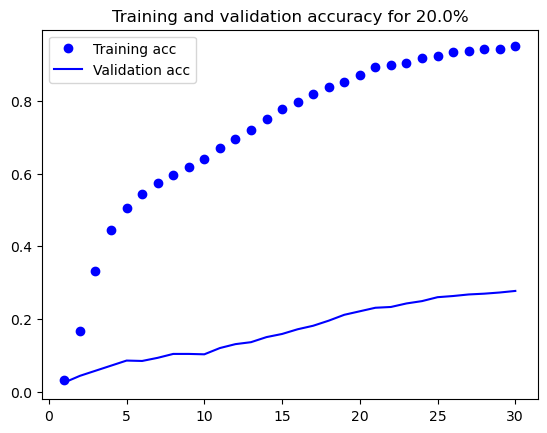

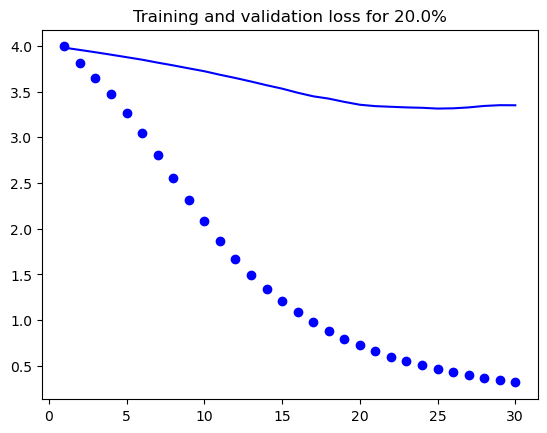

In [126]:
gan_trainacc = []
gan_trainloss = []
gan_valacc = []
gan_valloss = []
for i in range (len(ganhistory)):
    gan_trainacc.append(history[i].history['accuracy'])
    gan_trainloss.append(history[i].history['loss'])
    gan_valacc.append(history[i].history['val_accuracy'])
    gan_valloss.append(history[i].history['val_loss'])

acc = np.mean(gan_trainacc, axis=0)
val_acc = np.mean(gan_valacc, axis=0)
loss = np.mean(gan_trainloss, axis=0)
val_loss = np.mean(gan_valloss, axis=0)
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for {}%'.format(fraction_of_data*100))
plt.legend()#作用是加上图例，很有必要
plt.figure()#创建新图
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for {}%'.format(fraction_of_data*100))
# plt.legend()
# plt.savefig("./results/original/Train - {}%.png".format(fraction_of_data*100))
test_loss = np.mean(all_test_loss, axis=0)
test_acc = np.mean(all_test_acc, axis=0)

In [127]:
AccMean = np.mean(all_test_acc)
LossMean = np.mean(all_test_loss)
AccStd = np.std(all_test_acc)
LossStd = np.std(all_test_loss)

GanAccMean = np.mean(all_test_acc_gan)
GanLossMean = np.mean(all_test_loss_gan)
GanAccStd = np.std(all_test_acc_gan)
GanLossStd = np.std(all_test_loss_gan)

lines  = list()
lines.append("Original Data (Each Class: {} Real):".format(num_of_data))
lines.append("Accuracy mean: {}".format(AccMean))
lines.append("Loss mean: {}".format(LossMean))
lines.append("Accuracy STD: {}".format(AccStd))
lines.append("Loss STD: {} \n".format(LossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss[np.argmax(all_test_acc)]))

lines.append("\n ================== \n")
lines.append("Original + GAN Data" +
             "(Each Class: {} Real + {} GAN):".format(num_of_data, 
                                                      data_to_gen))
lines.append("Accuracy mean: {}".format(GanAccMean))
lines.append("Loss mean: {}".format(GanLossMean))
lines.append("Accuracy STD: {}".format(GanAccStd))
lines.append("Loss STD: {} \n".format(GanLossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc_gan)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss_gan[np.argmax(all_test_acc_gan)]))


file_dir = "./00csv_result/test - {}% - gen {}.txt".format(fraction_of_data*100,data_to_gen)
with open(file_dir, "w") as filehandle:
    for items in lines:
        filehandle.write('%s\n' % items)